# MSTAR Testing

encode_pretrained returns data and labels
encode_dataset returns just data


This is taking a while. I am going through this step by step and fixing it. 


## Clean this up

In [1]:
import graphlearning.active_learning as al
import graphlearning as gl
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import torchvision.models as torch_models
import timeit
import torch
import random

import utils
import batch_active_learning as bal
from importlib import reload

In [2]:
reload(bal)
reload(utils)

<module 'utils' from '/Users/jameschapman/Documents/GitHub/SAR_BAL/utils.py'>

In [3]:
#Pick one of 'mstar', 'open_sar', 'fusar'
dataset_chosen = 'mstar'

#This uses a CNNVAE to get embeddings
# **I think this actually uses the fully trained and not a CNNVAE
#Currently we always use the VAE for MSTAR since the knn_data is already stored for this

use_fully_trained_features = True
just_transfer              = False
transfer_and_train         = False

assert(use_fully_trained_features + just_transfer + transfer_and_train == 1)

#If you specify this, then it will use a specific trained NN for embeddings
#If none, it will pick the ones deemed optimal from prior testing
#  I recommend using None
transfer_encoding = None

#Determines the number of points in the coreset
#Larger values correspond to smaller coresets
density_radius_param = .5

knn_num = 17

In [4]:
start = timeit.default_timer()
with torch.no_grad():
  torch.cuda.empty_cache()

if dataset_chosen == 'open_sar':
  #Load labels
  data, labels = utils.load_dataset('open_sar_ship', return_torch = False, concatenate = True)
elif dataset_chosen == 'fusar':
  #Load labels
  data, labels = utils.load_dataset('fusar', return_torch = False, concatenate = True)
elif dataset_chosen == 'mstar':
  hdr, fields, mag, phase = utils.load_MSTAR('data/MSTAR/')
  data = utils.polar_transform(mag, phase)
  labels, target_names = utils.targets_to_labels(hdr)
else:
  assert False, "Chosen dataset could not be loaded. Check for typos"

knn_data = None

#Mimic that we know a percentage of data, and don't know for the rest
#Do transfer learning merely using these
percent_known_data = 0.05
known_data_ind = gl.trainsets.generate(labels, rate=percent_known_data).tolist()
known_data = data[known_data_ind]
known_labels = labels[known_data_ind]

# print(len(known_data))

#Generate the initial set
initial = gl.trainsets.generate(labels, rate=1).tolist()

#Percent of known data to use as training data for transfer learning
training_percent = 0.7
transfer_train_ind = random.sample(range(len(known_data)), round(len(known_data)*training_percent))
transfer_testing_ind = np.array([ind for ind in range(len(known_data)) if ind not in transfer_train_ind]).astype(int)

#Convert to torch for use
known_data = torch.from_numpy(known_data)
known_labels = torch.from_numpy(known_labels)


#print(len(transfer_testing_ind))
training_data = known_data[transfer_train_ind]
training_label = known_labels[transfer_train_ind]
testing_data = known_data[transfer_testing_ind]
testing_label = known_labels[transfer_testing_ind]

print(len(training_data))
print(len(testing_data))

data_info=[training_data, training_label, testing_data, testing_label]
for item in data_info:
  item = item.float()

        
if dataset_chosen == 'open_sar':
    #Load encoded dataset
    if use_fully_trained_features:
        X = utils.encode_dataset('open_sar_ship','./models/open_sar_ship_CNN.pt')
    elif just_transfer:
        X, labels = utils.encode_pretrained('open_sar_ship', 'AlexNet', transformed=True)
    else:
        X = utils.encode_transfer_learning('open_sar_ship', model_type='AlexNet', transfer_batch_size=64, epochs=30, data_info=data_info)
    #Load labels
    _, labels = utils.load_dataset('open_sar_ship', return_torch = False, concatenate = True)
    knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
elif dataset_chosen == 'fusar':
    #Load encoded dataset
    if use_fully_trained_features:
        X = utils.encode_dataset('fusar','./models/fusar_CNN.pt')
    elif just_transfer:
        X, labels = utils.encode_pretrained('fusar', 'ShuffleNet', normalized=True, transformed=True)
    else:
        X = utils.encode_transfer_learning('fusar', model_type='ShuffleNet', transfer_batch_size=64, epochs=30, data_info=data_info)
    #Load labels
    _, labels = utils.load_dataset('fusar', return_torch = False, concatenate = True)
    knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
elif dataset_chosen == 'mstar':
    knn_constructed = False
    if use_fully_trained_features:
        X = utils.encodeMSTAR('./models/SAR10_CNNVAE.pt', cuda=False)
        knn_data = gl.weightmatrix.load_knn_data('sar10', metric='cnnvae') #('knn_data/sar10_cnnvae.npz')
        knn_constructed = True
    elif just_transfer:
        X, labels = utils.encode_pretrained('mstar', 'ResNet', transformed=False)
    else:
        X = utils.encode_transfer_learning('mstar', model_type = None, transfer_batch_size=64, epochs=10, data_info=data_info)
    # X = utils.encode_transfer_learning(path, data_info=data_info, transformed=False)
    
    ##TODO: DUMB TESTING. COMMENT This out
    #X = X[:500]
    #labels = labels[:500]
    print("Constructing knn_data")
    if not knn_constructed:
        knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
    
    
else:
    assert False, "Chosen dataset could not be loaded. Check for typos"

print("Constructing Graph Learning Objects")
W = gl.weightmatrix.knn(X, knn_num, kernel = 'gaussian', knn_data=knn_data)
G = gl.graph(W)
end = timeit.default_timer()

print(X.shape)

print("Complete")
print(f"Time taken = {end - start}")

237
101
Constructing knn_data
Constructing Graph Learning Objects
(6874, 7744)
Complete
Time taken = 14.215898917


In [5]:
#Use the percent radius because it should be more robust across datasets
coreset = bal.coreset_dijkstras(G, rad = .2, DEBUGGING=False, data = X, initial=initial, 
                                density_info = (True, density_radius_param, 1), knn_data=knn_data)
print("Coreset Size = {}\t Percent of data = {}%".format(len(coreset), round(100 * len(coreset) / len(X), 2)))
print("Coreset = ", coreset)
print(labels[coreset])

Coreset Size = 16	 Percent of data = 0.23%
Coreset =  [3361, 889, 6212, 4650, 4595, 3536, 4832, 3860, 471, 1454, 4652, 1953, 5809, 6870, 1218, 289]
[0 1 2 3 4 5 6 7 8 9 3 8 7 3 1 8]


In [6]:
#acq_fun_list = ['uc', 'vopt', 'mc', 'mcvopt']
##TODO: Use the above one for actual testing
acq_fun_list = ['uc']
max_new_samples = 700
#max_new_samples = 3060
# max_new_samples = 2000
batchsize=15

L_time = []
L_num_labels = []
L_acc = []
L_names = []
for acq_fun in acq_fun_list:

  num_iter = int(max_new_samples/batchsize)

  al_mtd = 'local_max'
  print(acq_fun, al_mtd)
  start = timeit.default_timer() 
  _, list_num_labels, list_acc = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method='Laplace',
                           display=False, use_prior=False, al_mtd=al_mtd, debug=False,
                           acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
                           savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
                           dist_metric='angular', q=1, thresholding=0, randseed=0)
  stop = timeit.default_timer()
  L_time.append(stop - start)
  L_num_labels.append(list_num_labels)
  L_acc.append(list_acc)
  L_names.append(al_mtd)

uc local_max


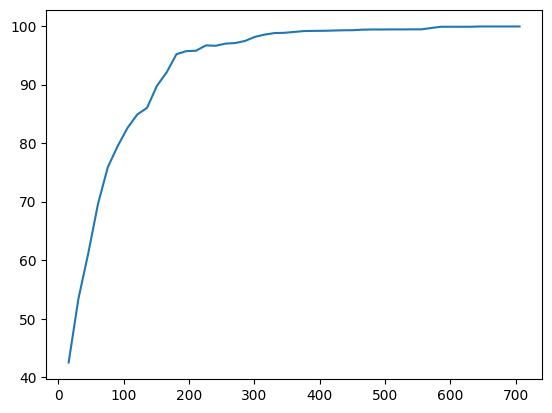

In [7]:
i=0
fig = plt.figure()
plt.plot(L_num_labels[i], L_acc[i])
#plt.set_ylim([None, 100])
plt.show()